* npyの保存

In [1]:
import librosa
import librosa.display
import random
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from keras.models import Sequential
from keras.layers import Dense, Activation,Dropout

### 男

mfccT_label_list_m = []

man_voices = glob.glob("./voice/man_30/*")

for voice in man_voices:
    waveform, sample_rate = librosa.load(voice)
    
    # mfcc作成
    mfcc = librosa.feature.mfcc(y = waveform,sr = sample_rate, n_mfcc = 20)

    # mfcc転置
    mfccT = mfcc.T

    # ラベルベクトルの作成
    label = np.full(mfccT.shape[0], 0)

    # mfccTをリスト
    mfccT_list = mfccT.tolist()

    # ([mfccT],label)の形に変換
    mfccT_label_list = list(zip(mfccT_list, label))

    mfccT_label_list_m = mfccT_label_list_m + mfccT_label_list

### 女

mfccT_label_list_f = []
woman_voices = glob.glob("./voice/female_30/*")

for voice in woman_voices:
    
    waveform, sample_rate = librosa.load(voice)

    # mfcc作成
    mfcc = librosa.feature.mfcc(y = waveform,sr = sample_rate, n_mfcc = 20)

    # mfcc転置
    mfccT = mfcc.T

    # ラベルベクトルの作成
    label = np.full(mfccT.shape[0], 1)

    # mfccTをリスト
    mfccT_list = mfccT.tolist()

    # ([mfccT],label)の形に変換
    mfccT_label_list = list(zip(mfccT_list, label))

    mfccT_label_list_f = mfccT_label_list_f + mfccT_label_list

if len(mfccT_label_list_f) >= len(mfccT_label_list_m):
    del mfccT_label_list_f[len(mfccT_label_list_m):]
else:
    del mfccT_label_list_m[len(mfccT_label_list_f):]

### 合成

# join
merge_list = mfccT_label_list_m + mfccT_label_list_f

# listのシャッフル
random.shuffle(merge_list)

# 逆変換
mfccT_re_tra = np.array([data[0] for data in merge_list[0:int(len(merge_list) * 0.6)]])
np.save('mfccT_re_tra.npy', mfccT_re_tra)
mfccT_re_val = np.array([data[0] for data in merge_list[int(len(merge_list) * 0.6):int(len(merge_list) * 0.8)]])
np.save('mfccT_re_val.npy', mfccT_re_val)
mfccT_re_test = np.array([data[0] for data in merge_list[int(len(merge_list) * 0.8):]])
np.save('mfccT_re_test.npy', mfccT_re_test)

label_re_tra = np.array([data[1] for data in merge_list[0:int(len(merge_list) * 0.6)]])
np.save('label_re_tra.npy', label_re_tra)
label_re_val = np.array([data[1] for data in merge_list[int(len(merge_list) * 0.6):int(len(merge_list) * 0.8)]])
np.save('label_re_val.npy', label_re_val)
label_re_test = np.array([data[1] for data in merge_list[int(len(merge_list) * 0.8):]])
np.save('label_re_test.npy', label_re_test)

Using TensorFlow backend.


* 完了

* 読みこませる

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 256)               5376      
_________________________________________________________________
activation_30 (Activation)   (None, 256)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 256)               65792     
_________________________________________________________________
activation_31 (Activation)   (None, 256)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 257       
_________________________________________________________________
activation_32 (Activation)   (None, 1)                 0         
Total params: 71,425
Trainable params: 71,425
Non-trainable params: 0
_________________________________________________________________
Train 

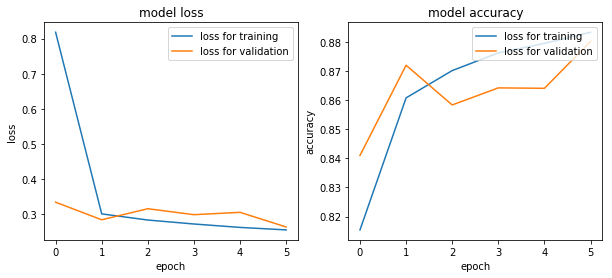

In [11]:
import librosa
import librosa.display
import random
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from keras.models import Sequential
from keras.layers import Dense, Activation,Dropout

# numpy読み込み
mfccT_re_tra = np.load('numpy/mfccT_re_tra.npy')
mfccT_re_val = np.load('numpy/mfccT_re_val.npy')
mfccT_re_test = np.load('numpy/mfccT_re_test.npy')

label_re_tra = np.load('numpy/label_re_tra.npy')
label_re_val = np.load('numpy/label_re_val.npy')
label_re_test = np.load('numpy/label_re_test.npy')

# モデルの作成
model = Sequential()

model.add(Dense(256, input_dim = 20))
model.add(Activation('relu'))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.summary()

# モデルのコンパイル
model.compile(loss = 'binary_crossentropy', optimizer = 'sgd', metrics=['accuracy'])

# 訓練の実行
fit = model.fit(mfccT_re_tra, label_re_tra, validation_data = [mfccT_re_val, label_re_val], epochs = 6, batch_size = 32)

# 予測
classes = model.predict(mfccT_re_test, batch_size = 32)

# 結果
score = model.evaluate(mfccT_re_test, label_re_test, batch_size = 32)
print(list(zip(model.metrics_names, score)))

# グラフの出力
fig, (axL, axR) = plt.subplots(ncols = 2, figsize = (10,4))

def plot_history_loss(fit):
    axL.plot(fit.history['loss'],label="loss for training")
    axL.plot(fit.history['val_loss'],label="loss for validation")
    axL.set_title('model loss')
    axL.set_xlabel('epoch')
    axL.set_ylabel('loss')
    axL.legend(loc='upper right')
    
def plot_history_acc(fit):
    axR.plot(fit.history['acc'],label="loss for training")
    axR.plot(fit.history['val_acc'],label="loss for validation")
    axR.set_title('model accuracy')
    axR.set_xlabel('epoch')
    axR.set_ylabel('accuracy')
    axR.legend(loc='upper right')
    
plot_history_loss(fit)
plot_history_acc(fit)
plt.show()
plt.close()

* でけた

* 学習の保存

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 512)               10752     
_________________________________________________________________
dense_26 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 513       
Total params: 273,921
Trainable params: 273,921
Non-trainable params: 0
_________________________________________________________________
Train on 121356 samples, validate on 40452 samples
Epoch 1/6
121356/121356 [==============================] - 12s 95us/step - loss: 0.8027 - acc: 0.8257 - val_loss: 0.3245 - val_acc: 0.8645
Epoch 2/6
121356/121356 [==============================] - 11s 93us/step - loss: 0.3051 - acc: 0.8685 - val_loss: 0.3068 - val_acc: 0.8722
Epoch 3/6
121356/121356 [==============================] - 11s 93us/ste

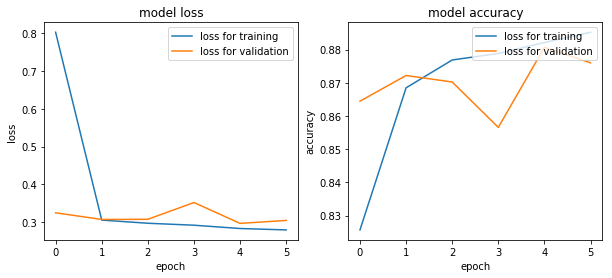

In [18]:
import librosa
import librosa.display
import random
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from keras.models import Sequential
from keras.layers import Dense, Activation,Dropout

# numpy読み込み
mfccT_re_tra = np.load('numpy/mfccT_re_tra.npy')
mfccT_re_val = np.load('numpy/mfccT_re_val.npy')
mfccT_re_test = np.load('numpy/mfccT_re_test.npy')

label_re_tra = np.load('numpy/label_re_tra.npy')
label_re_val = np.load('numpy/label_re_val.npy')
label_re_test = np.load('numpy/label_re_test.npy')

# モデルの作成
model = Sequential()

model.add(Dense(512, activation = 'relu', input_dim = 20))
model.add(Dense(512, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.summary()

# モデルのコンパイル
model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])

# 訓練の実行
fit = model.fit(mfccT_re_tra, label_re_tra, validation_data = [mfccT_re_val, label_re_val], epochs = 6, batch_size = 32)

# 重さの保存
model.save_weights('voice_learning_weight.h5')

# 予測
classes = model.predict(mfccT_re_test, batch_size = 32)

# 結果
score = model.evaluate(mfccT_re_test, label_re_test, batch_size = 32)
print(list(zip(model.metrics_names, score)))

# グラフの出力
fig, (axL, axR) = plt.subplots(ncols = 2, figsize = (10,4))

def plot_history_loss(fit):
    axL.plot(fit.history['loss'],label="loss for training")
    axL.plot(fit.history['val_loss'],label="loss for validation")
    axL.set_title('model loss')
    axL.set_xlabel('epoch')
    axL.set_ylabel('loss')
    axL.legend(loc='upper right')
    
def plot_history_acc(fit):
    axR.plot(fit.history['acc'],label="loss for training")
    axR.plot(fit.history['val_acc'],label="loss for validation")
    axR.set_title('model accuracy')
    axR.set_xlabel('epoch')
    axR.set_ylabel('accuracy')
    axR.legend(loc='upper right')
    
plot_history_loss(fit)
plot_history_acc(fit)
plt.show()
plt.close()

* 保存したのを使う

40452/40452 [==============================] - 1s 13us/step
[('loss', 0.27916283977632295), ('acc', 0.8742212993177099)]


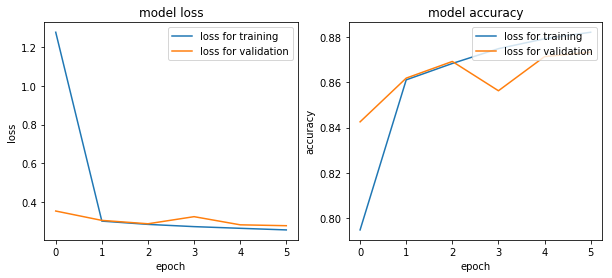

In [5]:
import librosa
import librosa.display
import random
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from keras.models import Sequential
from keras.layers import Dense, Activation,Dropout

# テストデータ読み込み
mfccT_re_test = np.load('numpy/mfccT_re_test.npy')
label_re_test = np.load('numpy/label_re_test.npy')

# 予測
classes = model.predict(mfccT_re_test, batch_size = 32)

# 結果
score = model.evaluate(mfccT_re_test, label_re_test, batch_size = 32)
print(list(zip(model.metrics_names, score)))

# グラフの出力
fig, (axL, axR) = plt.subplots(ncols = 2, figsize = (10,4))

def plot_history_loss(fit):
    axL.plot(fit.history['loss'],label="loss for training")
    axL.plot(fit.history['val_loss'],label="loss for validation")
    axL.set_title('model loss')
    axL.set_xlabel('epoch')
    axL.set_ylabel('loss')
    axL.legend(loc='upper right')
    
def plot_history_acc(fit):
    axR.plot(fit.history['acc'],label="loss for training")
    axR.plot(fit.history['val_acc'],label="loss for validation")
    axR.set_title('model accuracy')
    axR.set_xlabel('epoch')
    axR.set_ylabel('accuracy')
    axR.legend(loc='upper right')
    
plot_history_loss(fit)
plot_history_acc(fit)
plt.show()
plt.close()

* 新たなテストデータを作る

In [26]:
import librosa
import librosa.display
import random
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from keras.models import Sequential
from keras.layers import Dense, Activation,Dropout

### 男

mfccT_label_list_m = []

man_voices = glob.glob("./voice/man_test/*")

for voice in man_voices:
    waveform, sample_rate = librosa.load(voice)
    
    # mfcc作成
    mfcc = librosa.feature.mfcc(y = waveform,sr = sample_rate, n_mfcc = 20)

    # mfcc転置
    mfccT = mfcc.T

    # ラベルベクトルの作成
    label = np.full(mfccT.shape[0], 0)

    # mfccTをリスト
    mfccT_list = mfccT.tolist()

    # ([mfccT],label)の形に変換
    mfccT_label_list = list(zip(mfccT_list, label))

    mfccT_label_list_m = mfccT_label_list_m + mfccT_label_list

### 女

mfccT_label_list_f = []
woman_voices = glob.glob("./voice/female_test/*")

for voice in woman_voices:
    
    waveform, sample_rate = librosa.load(voice)

    # mfcc作成
    mfcc = librosa.feature.mfcc(y = waveform,sr = sample_rate, n_mfcc = 20)

    # mfcc転置
    mfccT = mfcc.T

    # ラベルベクトルの作成
    label = np.full(mfccT.shape[0], 1)

    # mfccTをリスト
    mfccT_list = mfccT.tolist()

    # ([mfccT],label)の形に変換
    mfccT_label_list = list(zip(mfccT_list, label))

    mfccT_label_list_f = mfccT_label_list_f + mfccT_label_list

if len(mfccT_label_list_f) >= len(mfccT_label_list_m):
    del mfccT_label_list_f[len(mfccT_label_list_m):]
else:
    del mfccT_label_list_m[len(mfccT_label_list_f):]

### 合成

# join
merge_list = mfccT_label_list_m + mfccT_label_list_f

# listのシャッフル
random.shuffle(merge_list)

# 逆変換
mfccT_re_tra = np.array([data[0] for data in merge_list[0:int(len(merge_list) * 0.2)]])
np.save('numpy/mfcc_test.npy', mfccT_re_tra)

label_re_tra = np.array([data[1] for data in merge_list[0:int(len(merge_list) * 0.2)]])
np.save('numpy/label_test.npy', label_re_tra)

* 学習を適用してみよう

11673/11673 [==============================] - 0s 14us/step
[('loss', 0.6921401397791598), ('acc', 0.7866015591791333)]


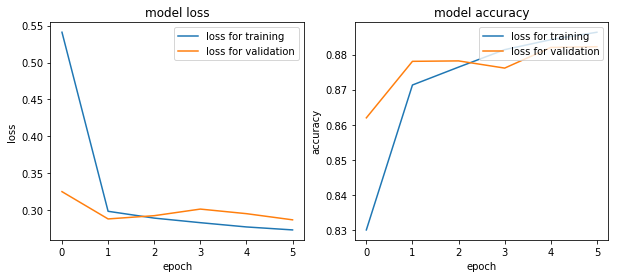

In [43]:
import librosa
import librosa.display
import random
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from keras.models import Sequential
from keras.layers import Dense, Activation,Dropout

# テストデータ読み込み
mfccT_re_test = np.load('numpy/mfcc_test.npy')
label_re_test = np.load('numpy/label_test.npy')

# 予測
classes = model.predict(mfccT_re_test, batch_size = 32)

# 結果
score = model.evaluate(mfccT_re_test, label_re_test, batch_size = 32)
print(list(zip(model.metrics_names, score)))

# グラフの出力
fig, (axL, axR) = plt.subplots(ncols = 2, figsize = (10,4))

def plot_history_loss(fit):
    axL.plot(fit.history['loss'],label="loss for training")
    axL.plot(fit.history['val_loss'],label="loss for validation")
    axL.set_title('model loss')
    axL.set_xlabel('epoch')
    axL.set_ylabel('loss')
    axL.legend(loc='upper right')
    
def plot_history_acc(fit):
    axR.plot(fit.history['acc'],label="loss for training")
    axR.plot(fit.history['val_acc'],label="loss for validation")
    axR.set_title('model accuracy')
    axR.set_xlabel('epoch')
    axR.set_ylabel('accuracy')
    axR.legend(loc='upper right')
    
plot_history_loss(fit)
plot_history_acc(fit)
plt.show()
plt.close()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_59 (Dense)             (None, 1024)              21504     
_________________________________________________________________
dense_60 (Dense)             (None, 1)                 1025      
Total params: 22,529
Trainable params: 22,529
Non-trainable params: 0
_________________________________________________________________
Train on 121356 samples, validate on 40452 samples
Epoch 1/6
121356/121356 [==============================] - 5s 40us/step - loss: 0.5410 - acc: 0.8300 - val_loss: 0.3252 - val_acc: 0.8620
Epoch 2/6
121356/121356 [==============================] - 4s 34us/step - loss: 0.2986 - acc: 0.8713 - val_loss: 0.2883 - val_acc: 0.8781
Epoch 3/6
121356/121356 [==============================] - 4s 34us/step - loss: 0.2894 - acc: 0.8764 - val_loss: 0.2927 - val_acc: 0.8782
Epoch 4/6
121356/121356 [==============================] - 4s 34us/st

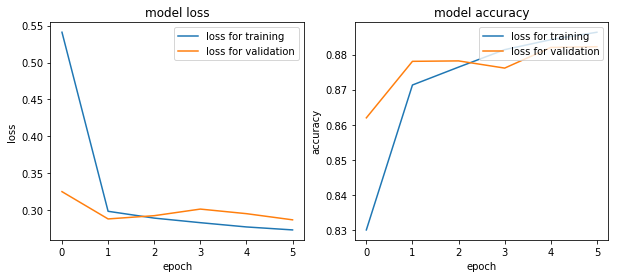

In [42]:
import librosa
import librosa.display
import random
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from keras.models import Sequential
from keras.layers import Dense, Activation,Dropout

# numpy読み込み
mfccT_re_tra = np.load('numpy/mfccT_re_tra.npy')
mfccT_re_val = np.load('numpy/mfccT_re_val.npy')
mfccT_re_test = np.load('numpy/mfccT_re_test.npy')

label_re_tra = np.load('numpy/label_re_tra.npy')
label_re_val = np.load('numpy/label_re_val.npy')
label_re_test = np.load('numpy/label_re_test.npy')

# モデルの作成
model = Sequential()

model.add(Dense(1024, activation = 'relu', input_dim = 20))
model.add(Dense(1, activation = 'sigmoid'))

model.summary()

# モデルのコンパイル
model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])

# 訓練の実行
fit = model.fit(mfccT_re_tra, label_re_tra, validation_data = [mfccT_re_val, label_re_val], epochs = 6, batch_size = 32)

# 重さの保存
model.save_weights('voice_learning_weight.h5')

# 予測
classes = model.predict(mfccT_re_test, batch_size = 32)

# 結果
score = model.evaluate(mfccT_re_test, label_re_test, batch_size = 32)
print(list(zip(model.metrics_names, score)))

# グラフの出力
fig, (axL, axR) = plt.subplots(ncols = 2, figsize = (10,4))

def plot_history_loss(fit):
    axL.plot(fit.history['loss'],label="loss for training")
    axL.plot(fit.history['val_loss'],label="loss for validation")
    axL.set_title('model loss')
    axL.set_xlabel('epoch')
    axL.set_ylabel('loss')
    axL.legend(loc='upper right')
    
def plot_history_acc(fit):
    axR.plot(fit.history['acc'],label="loss for training")
    axR.plot(fit.history['val_acc'],label="loss for validation")
    axR.set_title('model accuracy')
    axR.set_xlabel('epoch')
    axR.set_ylabel('accuracy')
    axR.legend(loc='upper right')
    
plot_history_loss(fit)
plot_history_acc(fit)
plt.show()
plt.close()